In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
import numpy as np

2025-02-01 10:38:20.611657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-01 10:38:20.697410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738402700.734929   15220 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738402700.746763   15220 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 10:38:20.847624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
loaded_encoder = np.load('encoder.npz')
one_hot_encoder = {key: loaded_encoder[key] for key in loaded_encoder}

In [3]:
VOCAB_SIZE: int = 91
SEQ_SIZE: int = 150

In [4]:
def split_encode(text: str) -> list[list[int]]:
    global one_hot_encoder
    global SEQ_SIZE
    encoded = [one_hot_encoder[x] for x in [*text][:SEQ_SIZE]]
    padded = encoded + [one_hot_encoder["<pad>"]] * (SEQ_SIZE - len(encoded))
    return padded

In [5]:
titles = np.load("dataset/text_shrink_other.npy")

In [6]:
data = np.array([split_encode(text) for text in titles])

In [7]:
BATCH_SIZE = 8

In [8]:
X = data[:, :-1, :] 
y = data[:, 1:, :] 

In [9]:
del data

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

W0000 00:00:1738402703.977424   15220 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
inputs = tf.keras.Input(shape=(SEQ_SIZE - 1, VOCAB_SIZE)) 
x = tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.3)(inputs)
query = tf.keras.layers.Dense(128)(x) 
key = tf.keras.layers.Dense(128)(x)    
value = tf.keras.layers.Dense(128)(x)  
attention_output = tf.keras.layers.Attention()([query, value, key])  
x = tf.keras.layers.Concatenate()([x, attention_output])  
x = tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [13]:
history = model.fit(dataset, epochs=8)

Epoch 1/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 270s 71ms/step - loss: 1.2879
Epoch 2/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 263s 70ms/step - loss: 0.4122
Epoch 3/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 261s 70ms/step - loss: 0.3328
Epoch 4/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 261s 70ms/step - loss: 0.3041
Epoch 5/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 267s 71ms/step - loss: 0.2840
Epoch 6/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 268s 71ms/step - loss: 0.2716
Epoch 7/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 266s 71ms/step - loss: 0.2635
Epoch 8/8
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 266s 71ms/step - loss: 0.2575


In [14]:
def encode(src: str) -> np.ndarray:
    dst = []
    for letter in [*src]:
        dst.append(one_hot_encoder[letter])
    return np.array(dst)

In [15]:
def decode(src: np.ndarray) -> str:
    dst = ""
    for coded in src:
        for key, val in one_hot_encoder.items():
            if (coded == val).all():
                dst += key
                break
    return dst

In [24]:
input_seq = encode("News: ")

In [25]:
def generate_sequence(model, start_sequence, seq_length, decode):
    padded_input = np.zeros((SEQ_SIZE - 1, start_sequence.shape[1]))
    padded_input[-start_sequence.shape[0]:] = start_sequence  
    current_input = np.copy(padded_input)
    generated_sequence = decode(current_input)  
    for _ in range(seq_length):
        predictions = model.predict(current_input[np.newaxis, ...], verbose=0) 
        next_char_idx = np.argmax(predictions[0, -1, :])
        next_char_onehot = np.zeros_like(current_input[0])
        next_char_onehot[next_char_idx] = 1
        current_input = np.roll(current_input, shift=-1, axis=0)
        current_input[-1] = next_char_onehot  
        generated_sequence += decode(next_char_onehot[np.newaxis, ...])
    return generated_sequence

In [26]:
generated_text = generate_sequence(model, input_seq, SEQ_SIZE, decode)
print(generated_text)

News: the ralendiccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc


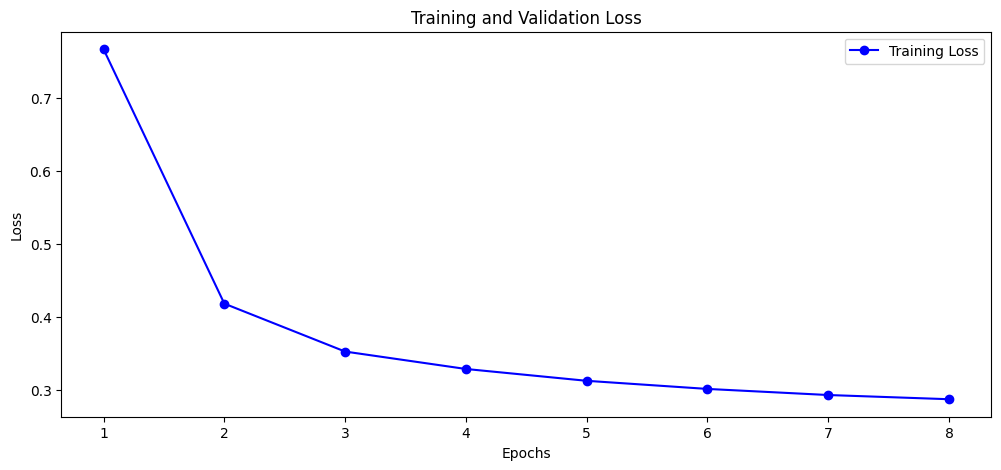

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']  
epochs = range(1, len(loss) + 1)  

val_loss = history_dict.get('val_loss', None)
accuracy = history_dict.get('accuracy', None)
val_accuracy = history_dict.get('val_accuracy', None)

plt.figure(figsize=(12, 5))

plt.plot(epochs, loss, 'bo-', label='Training Loss') 
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [20]:
model.save("generator_attention_long_seq_1.keras")